In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import lime
import lime.lime_tabular
import shap
import time
import sys
sys.path.append('../../wrapper')
import xgboost
import random

import mglearn
import sklearn
import sklearn.datasets

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectPercentile

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn import pipeline
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

import matplotlib
import matplotlib.pyplot as plt

In [4]:
class Timer(object):
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tstart = time.time()

    def __exit__(self, type, value, traceback):
        if self.name:
            print ('[%s]' % self.name)
        print ('Elapsed: %s' % (time.time() - self.tstart))

In [143]:
R = np.random.RandomState(0)
df = pd.DataFrame(R.randint(low=1, high=11, size=(10000, 1)), columns=['a'])
df['b'] = R.randint(low=1, high=11, size=(10000, 1))
#df['c'] = R.randint(low=1, high=10, size=(10000, 1))
df['a*b'] = df.a * df.b
df['a/b'] = df.a / df.b
#df['a*b*c'] = df.a * df.b * df.c

#df['y'] = np.where((df['a*b'] > 60)  , 'True', 'False')
df['y'] = np.where((df['a*b'] > 60) & (df['a'] < 8) , 'True', 'False')


for i in range(500):
    df[i+1] = R.randint(low=1, high=11, size=(10000, 1))
#df.plot.box()

In [144]:
df.describe()

,a,b,a*b,a/b,1,2,3,4,5,6,...,491,492,493,494,495,496,497,498,499,500
count,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.539700,5.445900,30.08080,1.644557,5.499000,5.505500,5.471700,5.526700,5.480800,5.494900,...,5.487500,5.455300,5.525200,5.502400,5.456700,5.575500,5.500300,5.474400,5.510800,5.478300
std,2.885525,2.861904,23.62931,1.864735,2.860283,2.847662,2.848896,2.875189,2.884417,2.887318,...,2.871179,2.848827,2.894789,2.859932,2.857926,2.868226,2.869325,2.858314,2.890591,2.895923
min,1.000000,1.000000,1.00000,0.100000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,10.00000,0.555556,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,6.000000,5.000000,24.00000,1.000000,5.000000,5.000000,6.000000,6.000000,5.000000,5.000000,...,5.000000,5.000000,6.000000,6.000000,5.000000,6.000000,5.000000,5.000000,5.000000,5.000000
75%,8.000000,8.000000,45.00000,2.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
max,10.000000,10.000000,100.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [145]:
df.groupby('y').count()

,a,b,a*b,a/b,1,2,3,4,5,6,...,491,492,493,494,495,496,497,498,499,500
y,,,,,,,,,,,,,,,,,,,,,
False,9828,9828,9828,9828,9828,9828,9828,9828,9828,9828,...,9828,9828,9828,9828,9828,9828,9828,9828,9828,9828
True,172,172,172,172,172,172,172,172,172,172,...,172,172,172,172,172,172,172,172,172,172


In [146]:
y = df.y
X = df.drop(['y'], 1)
feature_names = df.drop(['y'], 1).columns.values.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [147]:
le= sklearn.preprocessing.LabelEncoder()
le.fit(y)
labels = le.transform(y)
class_names = le.classes_
target_names = np.array(le.classes_)

In [148]:
rf = RandomForestClassifier(n_estimators=500, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [149]:
sklearn.metrics.accuracy_score(y_test, rf.predict(X_test))
print('Train score: {:.4f}'.format(rf.score(X_train, y_train)))
print('Test score: {:.4f}'.format(rf.score(X_test, y_test)))

Train score: 1.0000
Test score: 0.9785


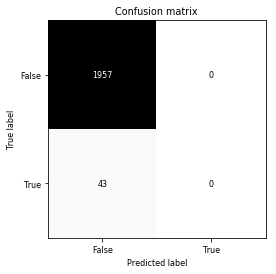

In [150]:
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test, rf.predict(X_test)), xlabel='Predicted label',
    ylabel='True label', xticklabels=target_names,
    yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

### Random under-sampling

In [151]:
print('y_resample:\n{}'.format(pd.Series(y_train).value_counts()))

y_resample:
False    7871
True      129
Name: y, dtype: int64


In [152]:
rus = RandomUnderSampler(random_state=0)
X_train_sampled, y_train_sampled = rus.fit_sample(X_train, y_train)
print('X_resampled.shape: {}, y_resampled: {}'.format(X_train_sampled.shape, y_train_sampled.shape))
print('y_resample:\n{}'.format(pd.Series(y_train_sampled).value_counts()))

X_resampled.shape: (258, 504), y_resampled: (258,)
y_resample:
True     129
False    129
dtype: int64


In [153]:
rf.fit(X_train_sampled, y_train_sampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [154]:
sklearn.metrics.accuracy_score(y_test, rf.predict(X_test))
print('Train score: {:.4f}'.format(rf.score(X_train_sampled, y_train_sampled)))
print('Test score: {:.4f}'.format(rf.score(X_test, y_test)))

Train score: 1.0000
Test score: 0.9550


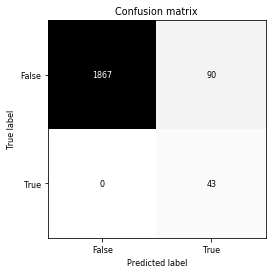

In [155]:
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test, rf.predict(X_test)), xlabel='Predicted label',
    ylabel='True label', xticklabels=target_names,
    yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

In [156]:
X_train_sampled = pd.DataFrame(X_train_sampled, columns=list(X_train))

### Feature selection

In [163]:
select = SelectFromModel(
    RandomForestClassifier(n_estimators=500, random_state=0),
    threshold="2.3*median")
#    threshold="6.7*median")

In [164]:
select.fit(X_train_sampled, y_train_sampled)
#X_train_selected = select.transform(X_train_sampled)
idxs_selected = select.get_support(indices=True)
X_train_selected = X_train_sampled.iloc[:, idxs_selected]

#X_test_selected = select.transform(X_test_sampled)
#idxs_selected = select.get_support(indices=True)
X_test_selected = X_test.iloc[:, idxs_selected]

print("X_train.shape: {}".format(X_train_sampled.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))
print("X_test_selected.shape: {}".format(X_test_selected.shape))

X_train.shape: (258, 504)
X_train_selected.shape: (258, 14)
X_test_selected.shape: (2000, 14)


In [165]:
feature_importances = select.estimator_.feature_importances_[idxs_selected]
idx = sorted(range(len(feature_importances)), key=lambda k: feature_importances[k])

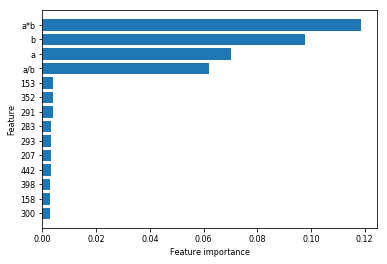

In [166]:
def plot_feature_importances(model):
    n_features = X_train_selected.shape[1]
    plt.barh(range(n_features), sorted(feature_importances), align='center')
    plt.yticks(np.arange(n_features), np.array(list(X_train_selected))[idx])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plt.rcParams.update({'font.size': 8})
plot_feature_importances(select)

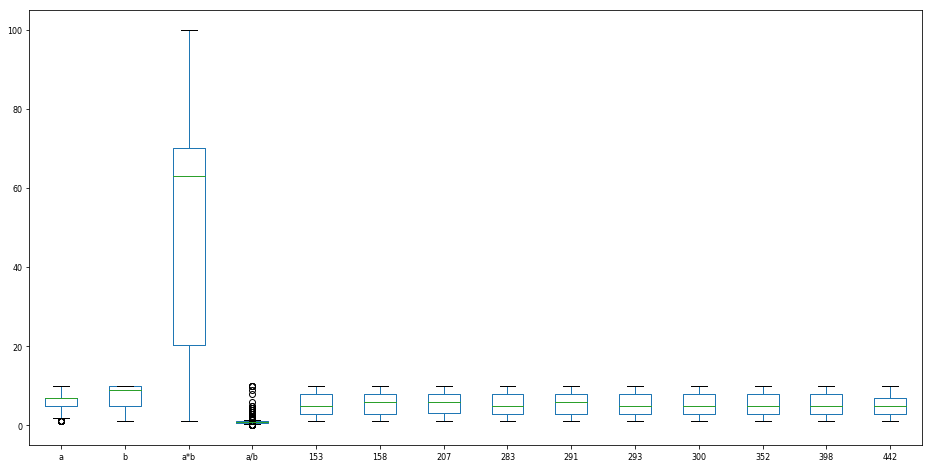

In [167]:
X_train_selected.plot.box(figsize=(16,8))

In [168]:
def classification(classifier):
    model = classifier
    model.fit(X_train_selected, y_train_sampled)
    cv_score = np.mean(cross_val_score(model, X_train_selected, y_train_sampled, cv=5))
    test_score = model.score(X_test_selected, y_test)
    print('Classifier parameters:', model.get_params)
    print("Cross-validation accuracy: {:.3f}".format(cv_score))    
    print('Test score: {:.3f}'.format(test_score))
    return model, cv_score, test_score

In [169]:
def confusion_matrix_plot(model):
    scores_image = mglearn.tools.heatmap(
        confusion_matrix(y_test, model.predict(X_test_selected)), xlabel='Predicted label',
        ylabel='True label', xticklabels=target_names,
        yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
    plt.title("Confusion matrix")
    plt.gca().invert_yaxis()

In [170]:
pipe = pipeline.Pipeline([('preprocessing', None), ('classifier', SVC())])
param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), MinMaxScaler(), None],
     'classifier__kernel': ['rbf', 'linear'],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
#     {'classifier': [RandomForestClassifier()], 'preprocessing': [StandardScaler(), None],
#      'classifier__n_estimators': [100, 500, 1000],
#      'classifier__bootstrap': [True, False],
#      'classifier__criterion': ['gini', 'entropy']},
]
     
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)

grid.fit(X_train_selected, y_train_sampled)
print("Best cross-validation accuracy: {:.3f}".format(grid.best_score_))
print("Test set score: {:.3f}".format(grid.score(X_test_selected, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.977
Test set score: 0.949
Best parameters: {'preprocessing': None, 'classifier__kernel': 'rbf', 'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__gamma': 0.001, 'classifier__C': 10}


In [171]:
svm_1, cv_score_svm_1, test_score_svm_1 = classification(SVC(C=1, gamma=0.01, probability=True))

Classifier parameters: <bound method BaseEstimator.get_params of SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)>
Cross-validation accuracy: 0.973
Test score: 0.940


In [ ]:
svm_2, cv_score_svm_2, test_score_svm_2 = classification(SVC(C=1000, gamma=0.001, kernel='linear', probability=True))

In [ ]:
clf = pipeline.Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(C=1000, gamma=0.1, kernel='linear', probability=True))])
pipe_test, cv_score_test, test_score_test = classification(clf)

In [98]:
svm_3, cv_score_svm_3, test_score_svm_3 = classification(SVC(C=1, gamma=1, probability=True))

Classifier parameters: <bound method BaseEstimator.get_params of SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)>
Cross-validation accuracy: 0.512
Test score: 0.975


In [99]:
svm_4, cv_score_svm_4, test_score_svm_4 = classification(SVC(C=1, gamma=10, probability=True))

Classifier parameters: <bound method BaseEstimator.get_params of SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)>
Cross-validation accuracy: 0.657
Test score: 0.463


In [104]:
rf_1, cv_score_rf_1, test_score_rf_1 = classification(RandomForestClassifier(n_estimators=10))

Classifier parameters: <bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>
Cross-validation accuracy: 1.000
Test score: 0.999


In [177]:
pipe_svm_minmax = pipeline.Pipeline([('preprocessing', MinMaxScaler()), ('classifier', SVC(C=100, gamma=0.1, probability=True))])
pipe_svm_minmax.fit(X_train_selected, y_train_sampled)
print('Train score: {:.4f}'.format(pipe_svm_minmax.score(X_train_selected, y_train_sampled)))
print("Test set score: {:.3f}".format(pipe_svm_minmax.score(X_test_selected, y_test_sampled)))

Train score: 1.0000
Test set score: 1.000


In [214]:
rf = RandomForestClassifier()
rf.fit(X_train_selected, y_train_sampled)
sklearn.metrics.accuracy_score(y_test_sampled, rf.predict(X_test_selected))
print('Train score: {:.4f}'.format(rf.score(X_train_selected, y_train_sampled)))
print('Test score: {:.4f}'.format(rf.score(X_test_selected, y_test_sampled)))

Train score: 1.0000
Test score: 1.0000


In [211]:
rf_500 = RandomForestClassifier(n_estimators=500)
rf_500.fit(X_train_selected, y_train_sampled)
sklearn.metrics.accuracy_score(y_test_sampled, rf_500.predict(X_test_selected))
print('Train score: {:.4f}'.format(rf_500.score(X_train_selected, y_train_sampled)))
print('Test score: {:.4f}'.format(rf_500.score(X_test_selected, y_test_sampled)))

Train score: 1.0000
Test score: 1.0000


In [179]:
pipe_rf_stdscaler = pipeline.Pipeline([('preprocessing', StandardScaler()), ('classifier', RandomForestClassifier())])
pipe_rf_stdscaler.fit(X_train_selected, y_train_sampled)
print('Train score: {:.4f}'.format(pipe_rf_stdscaler.score(X_train_selected, y_train_sampled)))
print("Test set score: {:.3f}".format(pipe_rf_stdscaler.score(X_test_selected, y_test_sampled)))

Train score: 1.0000
Test set score: 1.000


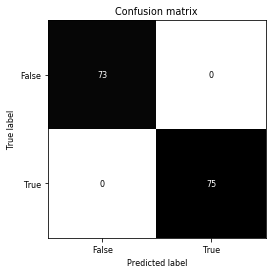

In [180]:
target_names = np.array(le.classes_)
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test_sampled, rf.predict(X_test_selected)), xlabel='Predicted label',
    ylabel='True label', xticklabels=target_names,
    yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

In [216]:
rf_10 = RandomForestClassifier(n_estimators=1)
rf_10.fit(X_train_selected, y_train_sampled)
sklearn.metrics.accuracy_score(y_test_sampled, rf_10.predict(X_test_selected))
print('Train score: {:.4f}'.format(rf_10.score(X_train_selected, y_train_sampled)))
print('Test score: {:.4f}'.format(rf_10.score(X_test_selected, y_test_sampled)))

Train score: 1.0000
Test score: 1.0000


### SHAP explaining predictions after under-sampling

In [111]:
explainer = shap.KernelExplainer(svm_1.predict_proba, X_train_selected)
sample = X_test_selected.sample(100, random_state=0)
shap_values_svm_1 = explainer.shap_values(X_test_selected.loc[sample.index])

100%|██████████| 100/100 [26:36<00:00, 15.97s/it]


In [229]:
shap.initjs()

In [236]:
i = 5
shap.force_plot(shap_values_rf[1][i], pd.DataFrame(X_test_selected).iloc[i,:])

In [271]:
shap.force_plot(shap_values_rf_500[1], pd.DataFrame(X_test_selected))

In [ ]:
pipe_svm_stdscaler
pipe_svm_minmax
pipe_rf_stdscaler

### SHAP explanation of SVM with Random undersampling

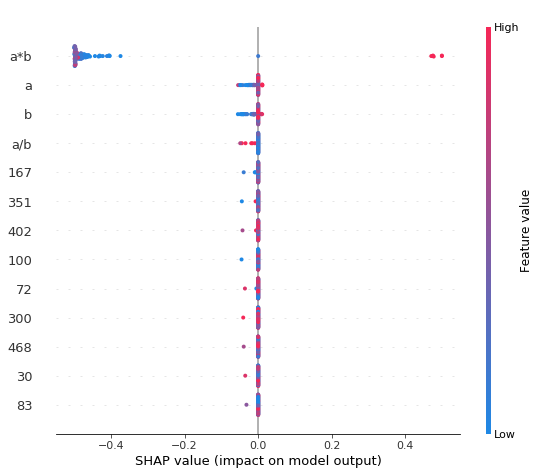

In [112]:
shap.summary_plot(shap_values_svm_1[1], X_test_selected.loc[sample.index])

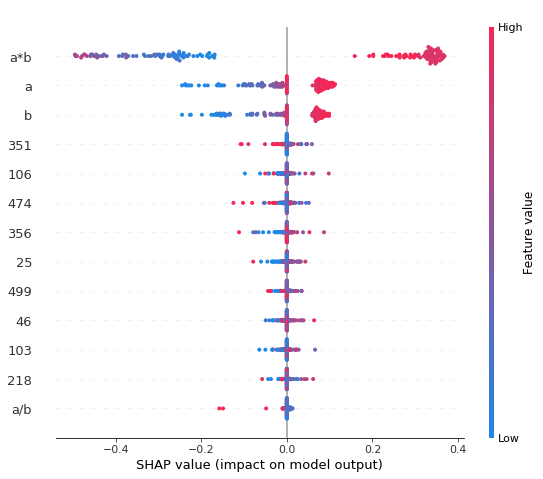

In [228]:
shap.summary_plot(shap_values_svm_fail[1], pd.DataFrame(X_test_selected))

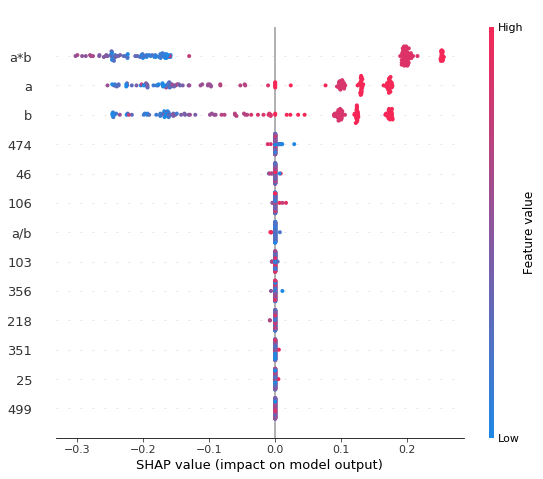

In [135]:
shap.summary_plot(shap_values_svm_stdscaler[1], pd.DataFrame(X_test_selected))

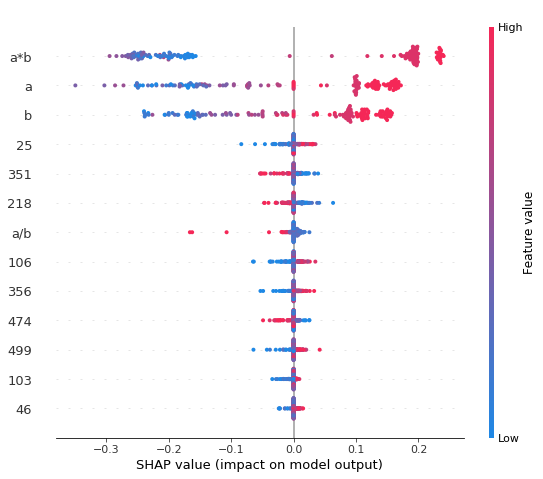

In [189]:
shap.summary_plot(shap_values_svm_stdscaler_fail[1], pd.DataFrame(X_test_selected))

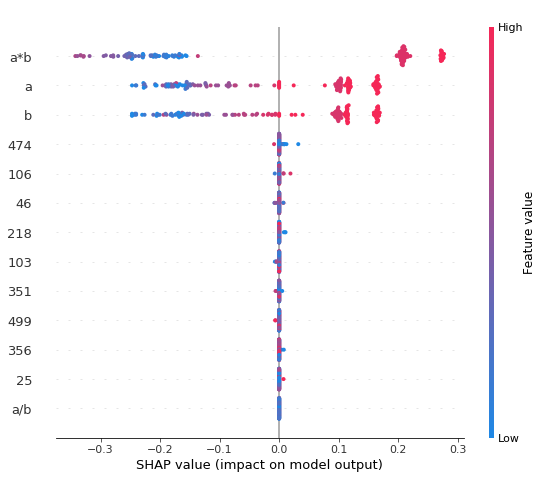

In [182]:
shap.summary_plot(shap_values_svm_minmax[1], pd.DataFrame(X_test_selected))

### SHAP explanation of Random Forests with Random undersampling

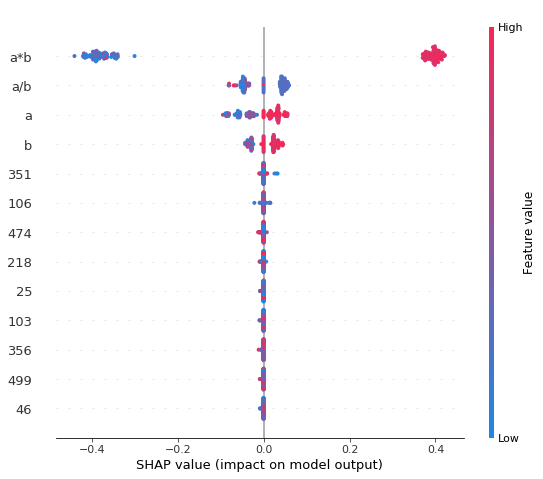

In [245]:
shap.summary_plot(shap_values_rf[1], pd.DataFrame(X_test_selected))

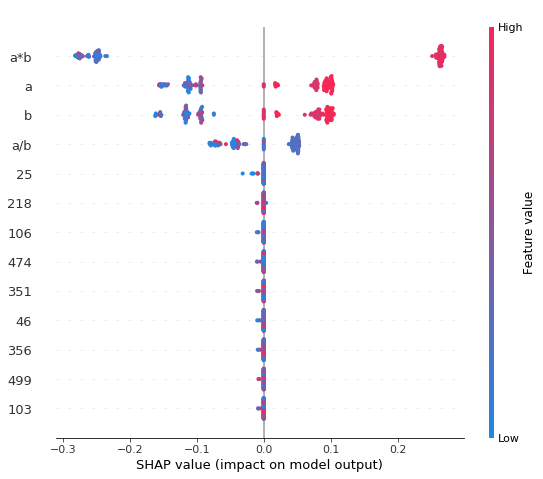

In [213]:
shap.summary_plot(shap_values_rf_500[1], pd.DataFrame(X_test_selected))

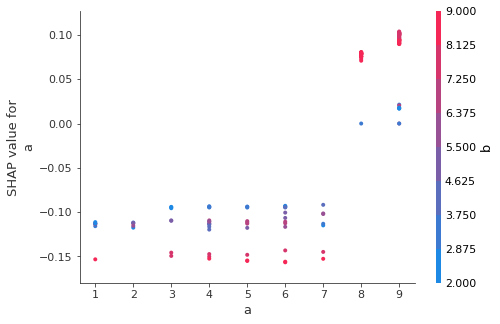

In [267]:
shap.dependence_plot("a", shap_values_rf_500[1], X_test_selected)

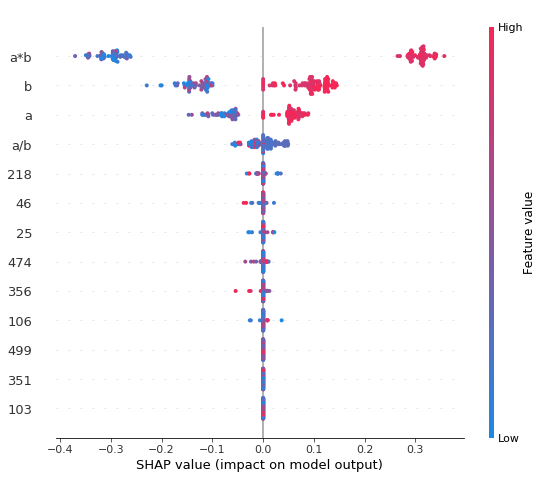

In [123]:
shap.summary_plot(shap_values_rf_stdscaler[1], pd.DataFrame(X_test_selected))

### SHAP explaining predictions of XGBoost

In [191]:
xgb_train = xgboost.DMatrix(X_train_selected, label=le.transform(y_train_sampled))
xgb_test = xgboost.DMatrix(X_test_selected, label=le.transform(y_test_sampled))

In [257]:
# use validation set to choose # of trees
params = {#'max_depth':20, 'n_estimators':100,
         'objective': 'multi:softmax', 'num_class': 2
}

xgb = xgboost.train(params, xgb_train, 1)

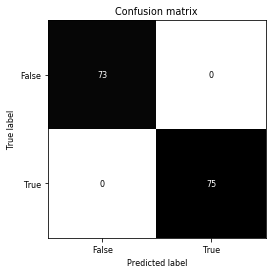

In [258]:
target_names = np.array(le.classes_)
scores_image = mglearn.tools.heatmap(
    confusion_matrix(le.transform(y_test_sampled), xgb.predict(xgb_test)), xlabel='Predicted label',
    ylabel='True label', xticklabels=target_names,
    yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

In [259]:
shap_values_xgb = xgb.predict(xgb_test, pred_contribs=True)

### SHAP explanation of XGBoost with Random undersampling

In [260]:
shap_interaction_values = xgb.predict(xgb_test, pred_interactions=True)

In [261]:
X_test_selected.columns = X_test_selected.columns.astype(str)

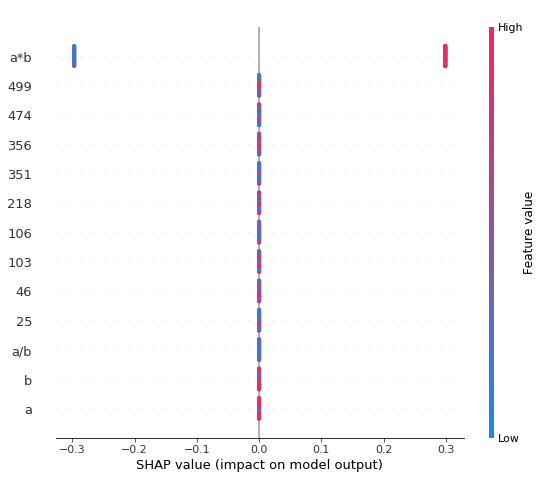

In [262]:
shap.summary_plot(shap_values_xgb[:, 1, :], X_test_selected)

/Users/lillian/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/lillian/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/lillian/anaconda3/lib/python3.5/site-packages/shap/plots.py:236: RuntimeWarning: invalid value encountered in absolute
  return np.argsort(-np.abs(interactions))


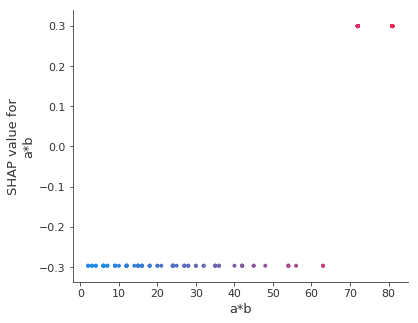

In [265]:
shap.dependence_plot("a*b", shap_values_xgb[:, 1, :], X_test_selected)

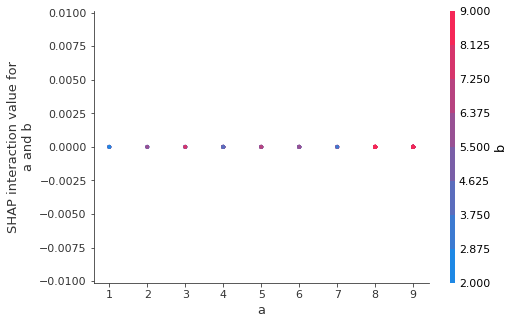

In [204]:
shap.dependence_plot(
    ("a", "b"),
    shap_interaction_values[:, 1, :, :], X_test_selected,
    display_features=X_test_selected
)